# PHL Temperature Forecasting

On this notebook, we will try to create models to forecast monthly max temperature in the Philippines. The data in this notebook is from the World Bank climate data and contains monthly values from 1901 to 2021. <br>

In [1]:
import pandas as pd
import numpy as np

from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm


plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (13, 5)
plt.rcParams["lines.linewidth"] = 0.8


In [2]:
from pathlib import os

def load_data(file_name):
    
    path = os.path.join(os.path.realpath(".."), "datasets", file_name)
    df = pd.read_csv(path, skiprows=2, index_col=0)
    
    df_np = df.to_numpy().flatten().reshape(-1, 1)
    
    idx = pd.date_range(start="1901-01-01", freq="MS", periods=len(df_np))
    df = pd.DataFrame(df_np, columns=["max_temp"], index=idx)
    
    return df

temp_df = load_data("tempmax_PHL_1901-2021.csv")
temp_df

,max_temp
1901-01-01,29.81
1901-02-01,28.93
1901-03-01,30.45
1901-04-01,32.07
1901-05-01,32.11
...,...
2021-08-01,30.94
2021-09-01,30.93
2021-10-01,30.80
2021-11-01,30.82


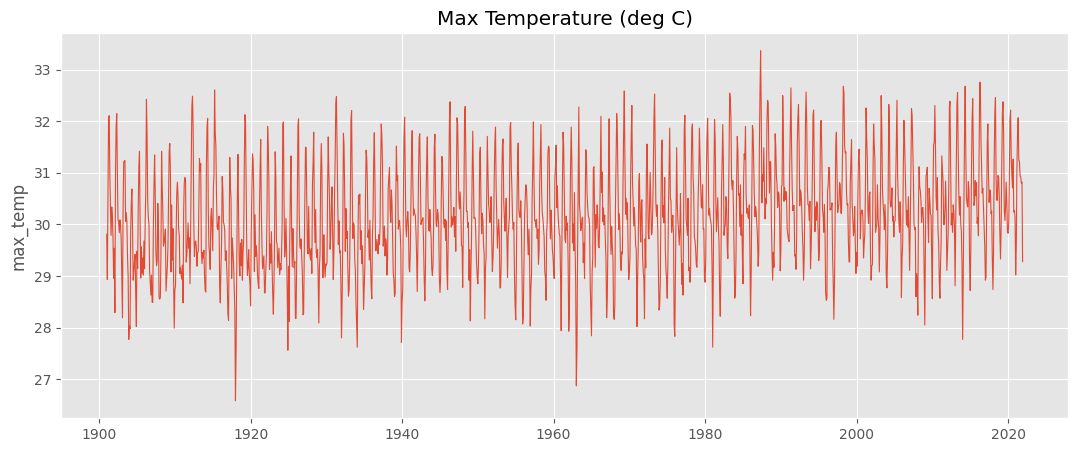

In [3]:
temp_ts = temp_df.max_temp

sns.lineplot(x=temp_ts.index, y=temp_ts)
ax = plt.gca()
ax.set_title("Max Temperature (deg C)")

plt.show()

We see in the timeseries above some multiyear seasonality. We also notice that the trend is roughly linear.

Text(0.5, 1.0, 'Monthly Average Max Temp. (deg C)')

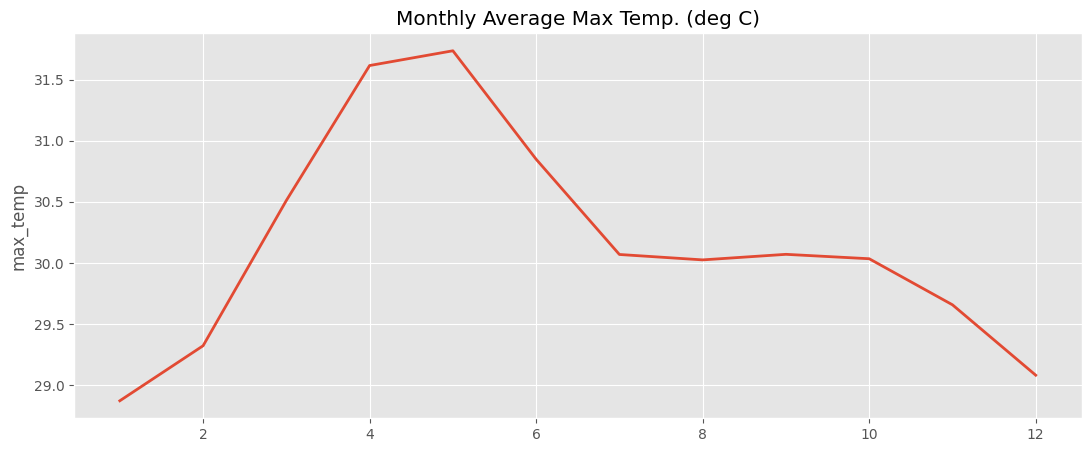

In [4]:
by_month = temp_ts.groupby(temp_ts.index.month).mean()
sns.lineplot(x=by_month.index, y=by_month, linewidth=2)
plt.title("Monthly Average Max Temp. (deg C)")

The hottest months seems to be April and May.

Text(0.5, 1.0, 'Variance by Year')

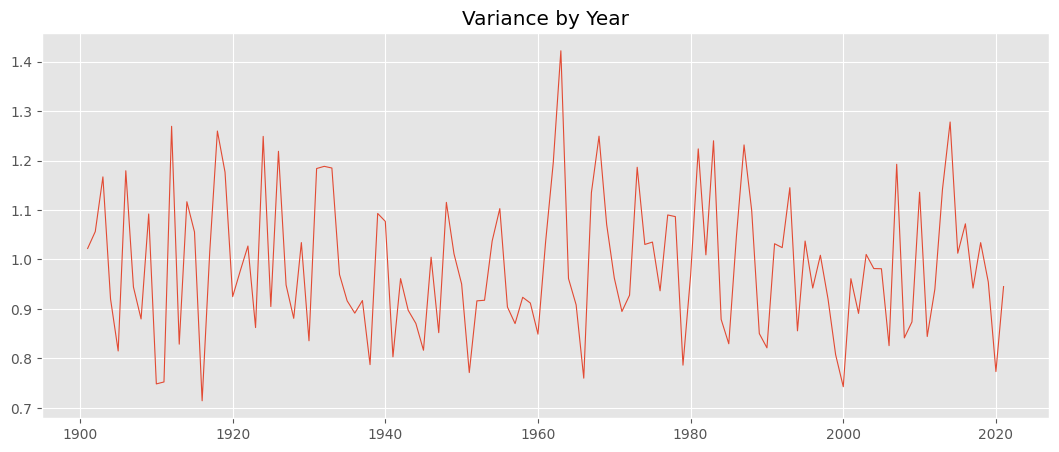

In [5]:
by_year = temp_ts.groupby(temp_ts.index.year).std()
by_year.plot()
plt.title("Variance by Year")

The time series seems to be homoscedastic, which means that we do not need to perform transforms such as box-cox transform.

In [7]:
from sklearn.metrics import mean_absolute_error
def plot_cf(ts):
    fig = plt.figure(figsize=(11, 6))
    
    fig.add_subplot(223)
    sm.tsa.graphics.plot_acf(ts, ax=plt.gca())
    
    fig.add_subplot(224)
    sm.tsa.graphics.plot_pacf(ts, ax=plt.gca(), method="ywm")
    
    fig.add_subplot(211)
    ts[ts.index.year > 1920].plot()
    plt.title("Residual Plot")
    plt.tight_layout()
    
    kpss = sm.tsa.stattools.kpss(ts)
    print("KPSS P-val: ", kpss[1])
    
def print_test(y, preds):
    mae = mean_absolute_error(y, preds)
    print("############################")
    print("MAE: ", mae)
    print("############################")

C:\Users\jamael\Documents\HandsOnML\venv\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


KPSS P-val:  0.01


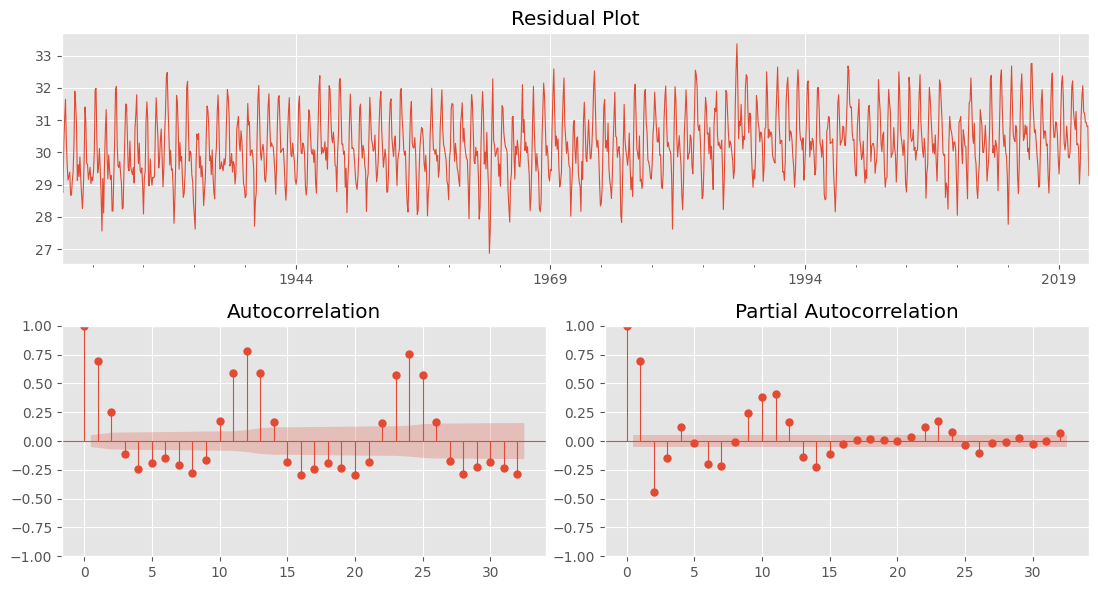

In [8]:
plot_cf(temp_ts)

We see a strong autocorrelation in the time series as seen above, we also notice the strong yearly seasonality.

In [9]:
test_size = 5

train_ts = temp_ts.iloc[:-test_size * 12]
test_ts = temp_ts.iloc[-test_size * 12:]

Let's leave out our last 5 years to be used as the test set

## ARIMA Models


C:\Users\jamael\Documents\HandsOnML\venv\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


KPSS P-val:  0.1


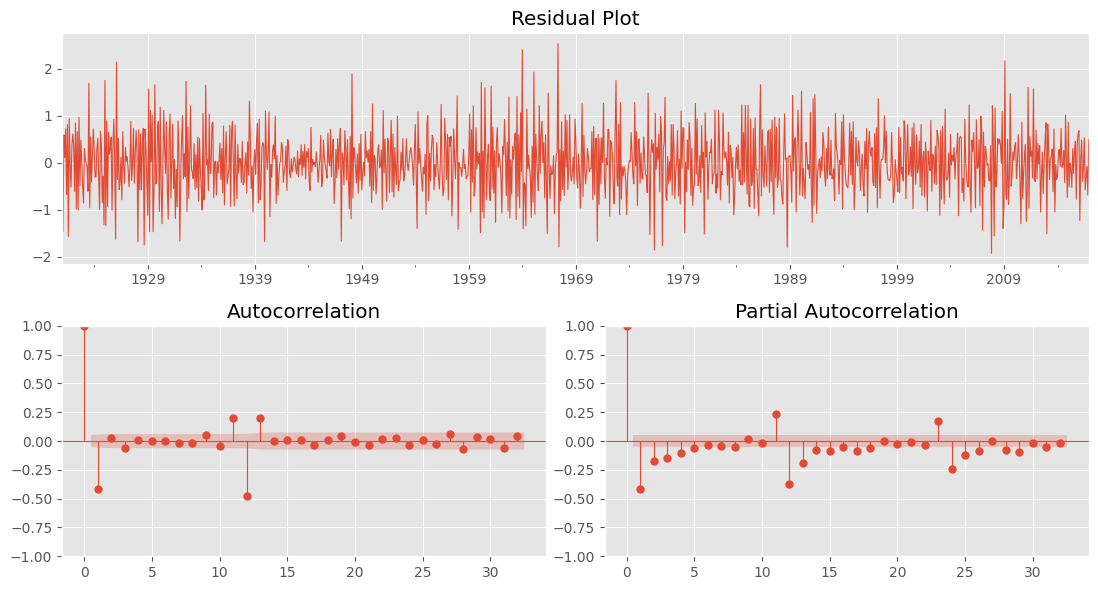

In [10]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.tools import diff

diff1 = diff(train_ts, k_diff=1, k_seasonal_diff=1, seasonal_periods=12)
plot_cf(diff1)

The acf plots suggests an MA(1) and seasonal MA(1) components <br>
The pacf plots suggests an AR(4) and seasonal AR(1) or AR(2)



In [11]:
arima011_011 = ARIMA(train_ts,
                    order=(0,1,1),
                    seasonal_order=(0,1,1,12)).fit()
print(arima011_011.summary())
fore1 = arima011_011.forecast(12*5)
print_test(test_ts, fore1)

                                    SARIMAX Results                                     
Dep. Variable:                         max_temp   No. Observations:                 1392
Model:             ARIMA(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -832.450
Date:                          Sun, 06 Aug 2023   AIC                           1670.901
Time:                                  21:29:34   BIC                           1686.588
Sample:                              01-01-1901   HQIC                          1676.769
                                   - 12-01-2016                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6116      0.021    -28.909      0.000      -0.653      -0.570
ma.S.L12      -0.9656      0.009   -111.645      0.

In [203]:
arima410_110 = ARIMA(train_ts,
                    order=(4,1,0),
                    seasonal_order=(1,1,0,12)).fit()
print(arima410_110.summary())
fore2 = arima410_110.forecast(5 * 12)
print_test(test_ts, fore2)

                                    SARIMAX Results                                     
Dep. Variable:                         max_temp   No. Observations:                 1392
Model:             ARIMA(4, 1, 0)x(1, 1, 0, 12)   Log Likelihood               -1099.646
Date:                          Sun, 06 Aug 2023   AIC                           2211.292
Time:                                  18:04:42   BIC                           2242.666
Sample:                              01-01-1901   HQIC                          2223.029
                                   - 12-01-2016                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5229      0.028    -18.663      0.000      -0.578      -0.468
ar.L2         -0.2807      0.029     -9.527      0.

In [12]:
arima410_210 = ARIMA(train_ts,
                    order=(4,1,0),
                    seasonal_order=(2,1,0,12)).fit()
print(arima410_210.summary())
fore3 = arima410_210.forecast(5 * 12)
print_test(test_ts, fore3)

                                    SARIMAX Results                                     
Dep. Variable:                         max_temp   No. Observations:                 1392
Model:             ARIMA(4, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -1022.996
Date:                          Sun, 06 Aug 2023   AIC                           2059.992
Time:                                  21:29:36   BIC                           2096.596
Sample:                              01-01-1901   HQIC                          2073.686
                                   - 12-01-2016                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5105      0.028    -18.275      0.000      -0.565      -0.456
ar.L2         -0.2799      0.029     -9.557      0.

## Results 
We see that the best model according to the smallest AIC and MAE is the MA(1) with seasonal MA(1) component

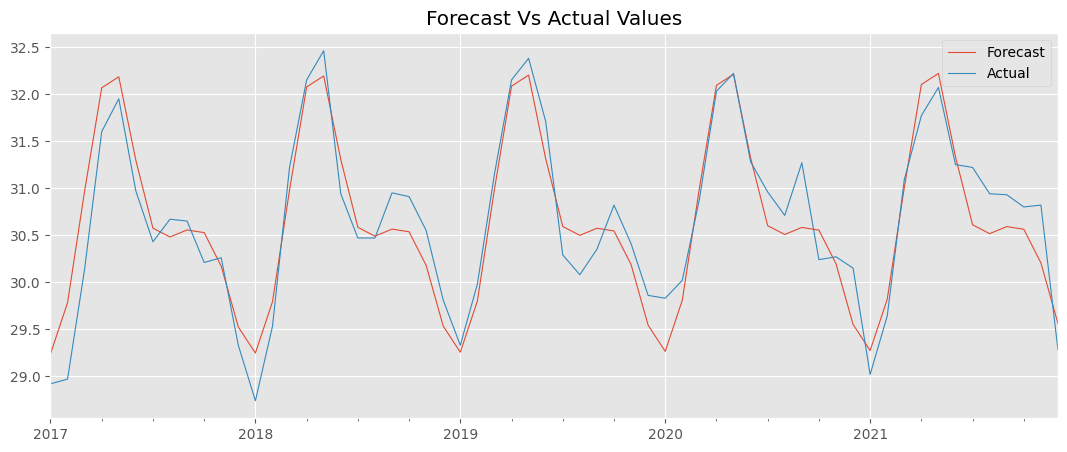

In [13]:
fore1.plot(label="Forecast")
test_ts.plot(label="Actual")
plt.title("Forecast Vs Actual Values")
plt.legend()

C:\Users\jamael\Documents\HandsOnML\venv\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


KPSS P-val:  0.1


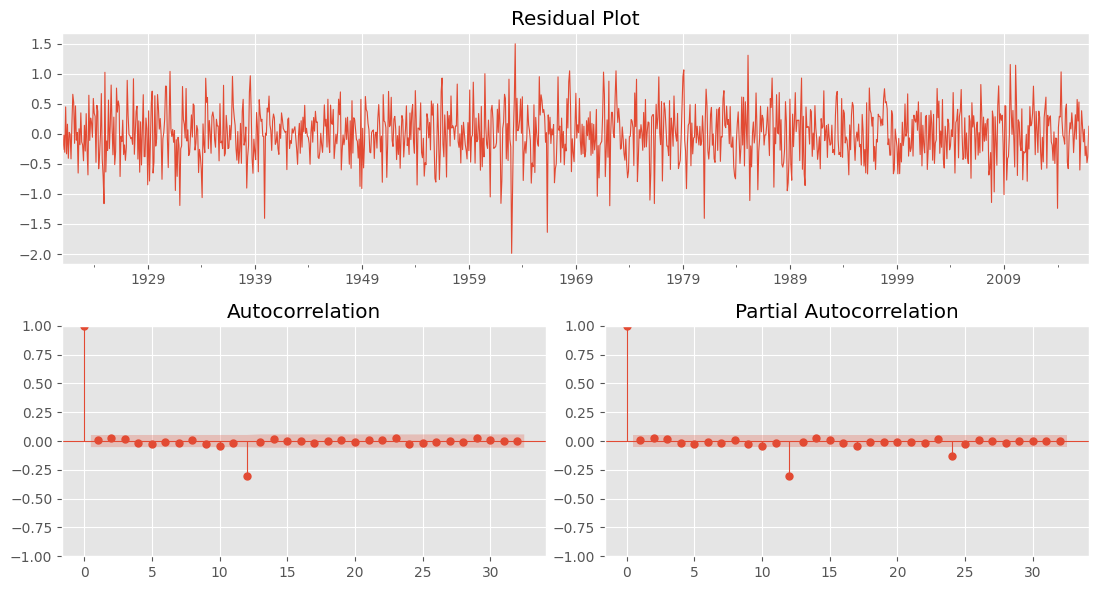

In [14]:
resid = train_ts - arima011_011.predict()
plot_cf(resid)

The spike on the 12th month is worrisome. Let's perform a ljung-box test.

In [15]:
ljung_box = sm.stats.diagnostic.acorr_ljungbox(resid,
                                              lags=48,
                                              model_df=2)
ljung_box.iloc[12]

lb_stat      1.354038e+02
lb_pvalue    1.398561e-23
Name: 13, dtype: float64

The pvalue is significant, which means that our residuals contain some serial correlation. Lets try some other models.

In [16]:
from pmdarima.arima import auto_arima

auto = auto_arima(train_ts, m=12,
                 start_p=0,
                 start_q=1,
                 start_P=0,
                 start_Q=1).fit(train_ts)
print(auto.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 1392
Model:             SARIMAX(5, 1, 1)x(2, 0, [], 12)   Log Likelihood               -1024.790
Date:                             Sun, 06 Aug 2023   AIC                           2069.580
Time:                                     21:33:17   BIC                           2121.958
Sample:                                 01-01-1901   HQIC                          2089.166
                                      - 12-01-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.422e-05      0.000      0.096      0.924      -0.000       0.000
ar.L1          0.4535      

Lets compare the performance of this model to our best model in the test set.

In [19]:

arima511_200 = sm.tsa.SARIMAX(train_ts,
                    order=(5,1,1),
                    seasonal_order=(2,0,0,12)).fit(maxiter=500)
print(arima511_200.summary())
fore5 = arima511_200.forecast(5 * 12)
print_test(test_ts, fore5)

                                      SARIMAX Results                                      
Dep. Variable:                            max_temp   No. Observations:                 1392
Model:             SARIMAX(5, 1, 1)x(2, 0, [], 12)   Log Likelihood               -1017.132
Date:                             Sun, 06 Aug 2023   AIC                           2052.264
Time:                                     21:34:19   BIC                           2099.404
Sample:                                 01-01-1901   HQIC                          2069.891
                                      - 12-01-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4168      0.028     14.823      0.000       0.362       0.472
ar.L2          0.1625      

C:\Users\jamael\Documents\HandsOnML\venv\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


KPSS P-val:  0.1


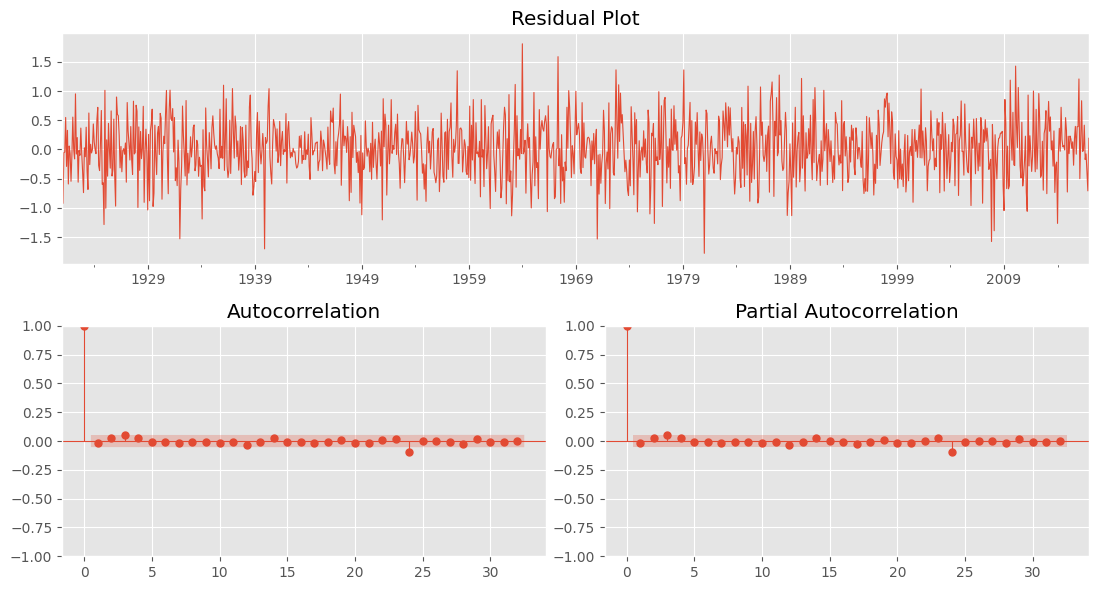

In [21]:
resid5 = train_ts - arima511_200.predict()
plot_cf(resid5)

## RESULT
The best ARIMA model that we choose is the ARIMA(0,1,1)(0,1,1)12 on the merit that it has the lowest AIC on our tested model and has the best forecasting performance on the 5 year test set.

In [22]:
best_maxtemp_model = ARIMA(temp_ts,
                          order=(0,1,1),
                          seasonal_order=(0,1,1,12)).fit()
print(best_maxtemp_model.summary())
forecast = best_maxtemp_model.forecast(5 * 12)

                                    SARIMAX Results                                     
Dep. Variable:                         max_temp   No. Observations:                 1452
Model:             ARIMA(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -854.871
Date:                          Sun, 06 Aug 2023   AIC                           1715.741
Time:                                  21:35:15   BIC                           1731.557
Sample:                              01-01-1901   HQIC                          1721.645
                                   - 12-01-2021                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6120      0.021    -29.693      0.000      -0.652      -0.572
ma.S.L12      -0.9646      0.009   -113.174      0.

[]

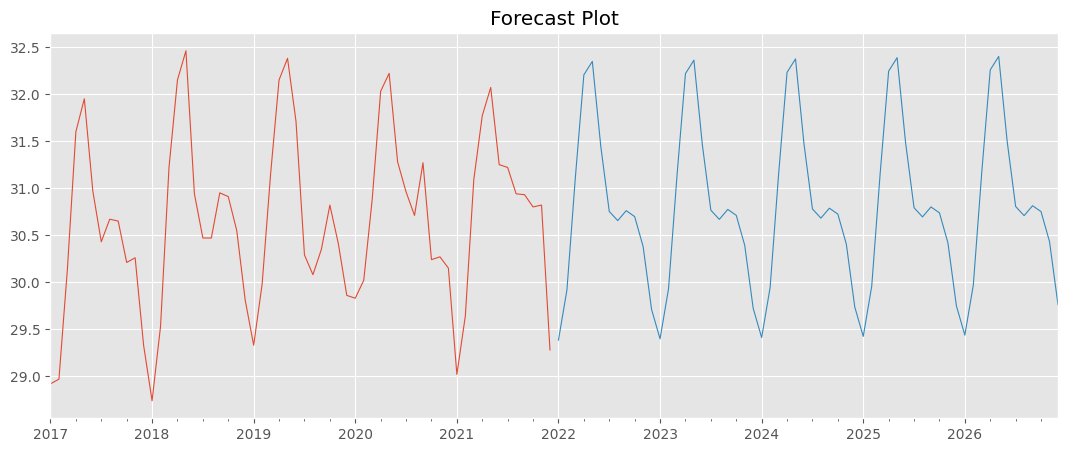

In [24]:
test_ts.plot(label="Previous Values")
plt.title("Forecast Plot")
forecast.plot(label="Forecast")
plt.plot()

## Seasonal Exogenous Regressors

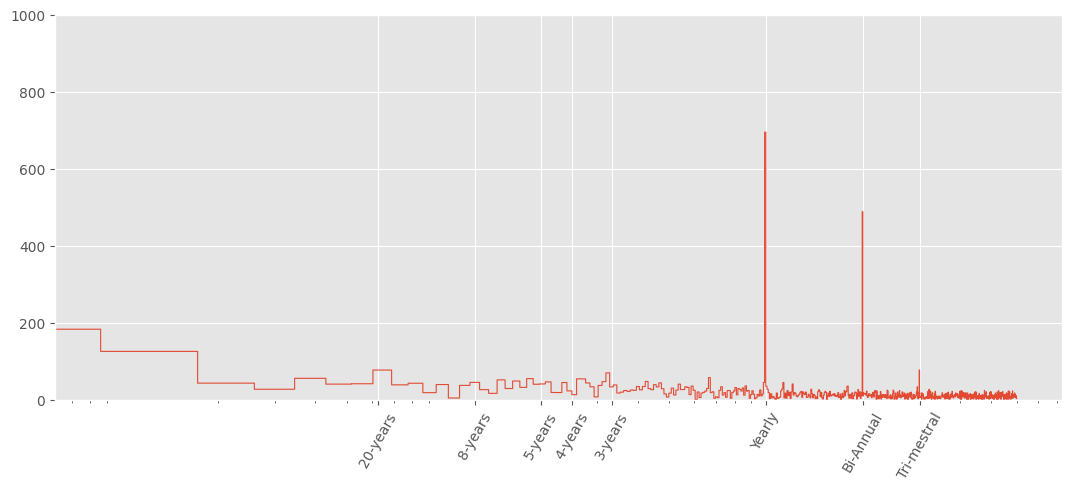

In [25]:
from scipy.fft import rfft
fft = np.abs(rfft(train_ts.to_numpy()))
fft_freqs = np.arange(len(fft))

years_per_ts = len(train_ts) / 12 
yr_per_ts = fft_freqs / years_per_ts

plt.step(x=yr_per_ts, y=fft) 
plt.xscale("log")
plt.ylim(0, 1000)
plt.xticks(rotation=60)
plt.xticks([1, 2, 3, 0.25, 0.2, 1/3, 1/8, 1/16],
          ["Yearly", "Bi-Annual", "Tri-mestral", "4-years", "5-years", "3-years", "8-years", "20-years"])
plt.show()



We see from the periodogram above the strong yearly, semi-annual, and 4-month seasonality in the time series.

In [26]:
def create_fourier_features(ts, season_lengths, create_fore=False, n=0):
    df = pd.DataFrame()
    length = len(ts)
    
    if create_fore:
        length += n
        
    steps = np.arange(length)
    
    for season in season_lengths:
        
        sin = np.sin((steps * 2 * np.pi) / season)
        cos = np.cos((steps * 2 * np.pi) / season)
        
        df["cos({:.2f})".format(season)] = cos
        df["sin({:.2f})".format(season)] = sin
        
    if create_fore:
        return df.iloc[:-n], df.iloc[-n:]
    
    df.index = ts.index
    return df

In [27]:
fft_df = pd.DataFrame(fft[1:], columns=["fft"], index=yr_per_ts[1:])

In [28]:
fft_df["Season Length (Years)"] = 1 / fft_df.index
fft_df["Season Length (Month)"] = (1 / fft_df.index) * 12

lengths = fft_df[fft_df["Season Length (Years)"] <= 20].sort_values(by="fft", ascending=False).head(10)
lengths

,fft,Season Length (Years),Season Length (Month)
1.000000,696.495174,1.000000,12.000000
2.000000,489.842444,0.500000,6.000000
3.000000,78.836028,0.333333,4.000000
0.068966,78.567252,14.500000,174.000000
0.327586,71.262481,3.052632,36.631579
0.672414,59.027409,1.487179,17.846154
0.189655,56.333694,5.272727,63.272727
0.267241,55.750982,3.741935,44.903226
0.275862,55.560554,3.625000,43.500000
0.155172,53.038701,6.444444,77.333333


We take top 10 most significant fourier components as part of our model. This yields 20 fourier pairs as our exogenous regressors.

In [29]:
n = lengths["Season Length (Month)"]
exog_train, exog_test = create_fourier_features(train_ts, n, create_fore=True, n=len(test_ts))
exog_train.index = train_ts.index
exog_train

,cos(12.00),sin(12.00),cos(6.00),sin(6.00),cos(4.00),sin(4.00),cos(174.00),sin(174.00),cos(36.63),sin(36.63),cos(17.85),sin(17.85),cos(63.27),sin(63.27),cos(44.90),sin(44.90),cos(43.50),sin(43.50),cos(77.33),sin(77.33)
1901-01-01,1.000000e+00,0.000000,1.0,0.000000e+00,1.000000e+00,0.000000e+00,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
1901-02-01,8.660254e-01,0.500000,0.5,8.660254e-01,6.123234e-17,1.000000e+00,0.999348,0.036102,0.985326,0.170684,0.938659,0.344846,0.995073,0.099140,0.990226,0.139471,0.989587,0.143939,0.996701,0.081159
1901-03-01,5.000000e-01,0.866025,-0.5,8.660254e-01,-1.000000e+00,1.224647e-16,0.997393,0.072158,0.941734,0.336359,0.762162,0.647386,0.980342,0.197303,0.961096,0.276216,0.958563,0.284881,0.986827,0.161782
1901-04-01,6.123234e-17,1.000000,-1.0,1.224647e-16,-1.836970e-16,-1.000000e+00,0.994138,0.108119,0.870504,0.492162,0.492162,0.870504,0.955952,0.293523,0.913178,0.407561,0.907575,0.419889,0.970441,0.241338
1901-05-01,-5.000000e-01,0.866025,-0.5,-8.660254e-01,1.000000e+00,-2.449294e-16,0.989587,0.143939,0.773726,0.633521,0.161782,0.986827,0.922143,0.386850,0.847410,0.530940,0.837686,0.546152,0.947653,0.319302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-08-01,-8.660254e-01,-0.500000,0.5,8.660254e-01,-1.435490e-13,-1.000000e+00,0.983745,-0.179572,0.654240,-0.756287,-0.188445,-0.982084,0.879248,-0.476365,0.765076,-0.643939,0.750350,-0.661041,0.918613,-0.395159
2016-09-01,-5.000000e-01,-0.866025,-0.5,8.660254e-01,1.000000e+00,2.159092e-14,0.989587,-0.143939,0.773726,-0.633521,0.161782,-0.986827,0.922143,-0.386850,0.847410,-0.530940,0.837686,-0.546152,0.947653,-0.319302
2016-10-01,-5.144321e-14,-1.000000,-1.0,1.028864e-13,2.680165e-13,1.000000e+00,0.994138,-0.108119,0.870504,-0.492162,0.492162,-0.870504,0.955952,-0.293523,0.913178,-0.407561,0.907575,-0.419889,0.970441,-0.241338
2016-11-01,5.000000e-01,-0.866025,-0.5,-8.660254e-01,-1.000000e+00,1.028765e-13,0.997393,-0.072158,0.941734,-0.336359,0.762162,-0.647386,0.980342,-0.197303,0.961096,-0.276216,0.958563,-0.284881,0.986827,-0.161782


In [30]:
exog_model = sm.tsa.SARIMAX(train_ts,
                           exog=exog_train,
                           order=(5, 1, 1),
                           ).fit(maxiter=1000)
print(exog_model.summary())

                               SARIMAX Results                                
Dep. Variable:               max_temp   No. Observations:                 1392
Model:               SARIMAX(5, 1, 1)   Log Likelihood                -743.046
Date:                Sun, 06 Aug 2023   AIC                           1540.092
Time:                        21:36:30   BIC                           1681.512
Sample:                    01-01-1901   HQIC                          1592.975
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
cos(12.00)     -0.6901      0.021    -32.309      0.000      -0.732      -0.648
sin(12.00)      0.7248      0.023     31.506      0.000       0.680       0.770
cos(6.00)      -0.6746      0.017    -40.799    

C:\Users\jamael\Documents\HandsOnML\venv\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


KPSS P-val:  0.1


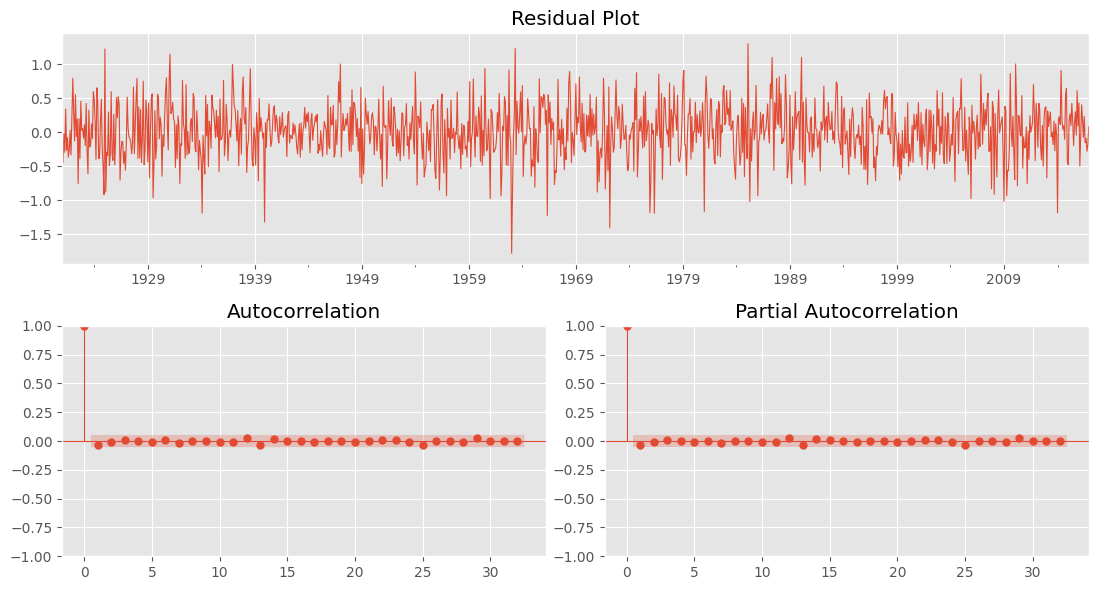

In [31]:
exog_fits = exog_model.predict()
exog_resids = train_ts - exog_fits
plot_cf(exog_resids)

The significant spikes that has been bothering us on our previous best model is now gone. Let's see the performance on the test set.

In [32]:
exog_test.index = test_ts.index
exog_forecast = exog_model.forecast(exog=exog_test, steps=5 * 12)
print_test(test_ts, exog_forecast)

############################
MAE:  0.36209529893392933
############################


The performance on the test set is surprisingly worse, it means that our simpler model generalizes better.

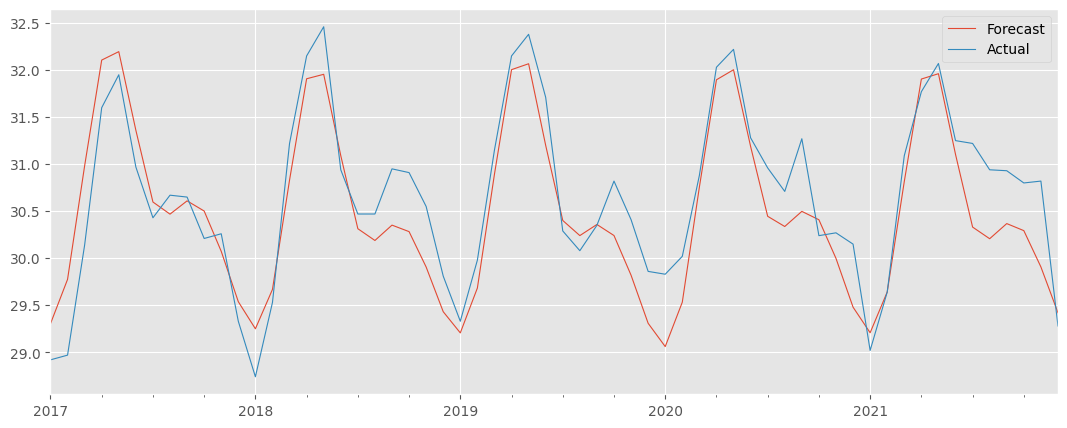

In [33]:
exog_forecast.plot(label="Forecast")
test_ts.plot(label="Actual")
plt.legend()

In [186]:
auto_model2 = auto = auto_arima(train_ts, X=exog_train,
                                 m=12,
                                 start_p=0,
                                 start_q=1,
                                 start_P=0,
                                 start_Q=1).fit(train_ts, exog_train)
print(auto_model2.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1392
Model:               SARIMAX(1, 1, 2)   Log Likelihood                -743.352
Date:                Sun, 06 Aug 2023   AIC                           1534.705
Time:                        17:14:07   BIC                           1660.412
Sample:                    01-01-1901   HQIC                          1581.712
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
cos(12.00)     -0.6901      0.021    -32.426      0.000      -0.732      -0.648
sin(12.00)      0.7248      0.023     31.730      0.000       0.680       0.770
cos(6.00)      -0.6746      0.016    -41.250    

Using the auto-ARIMA with exogenous regressors, the best model found is an ARIMA(1,1,2) model

C:\Users\jamael\Documents\HandsOnML\venv\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


KPSS P-val:  0.1
############################
MAE:  0.36229588505894994
############################


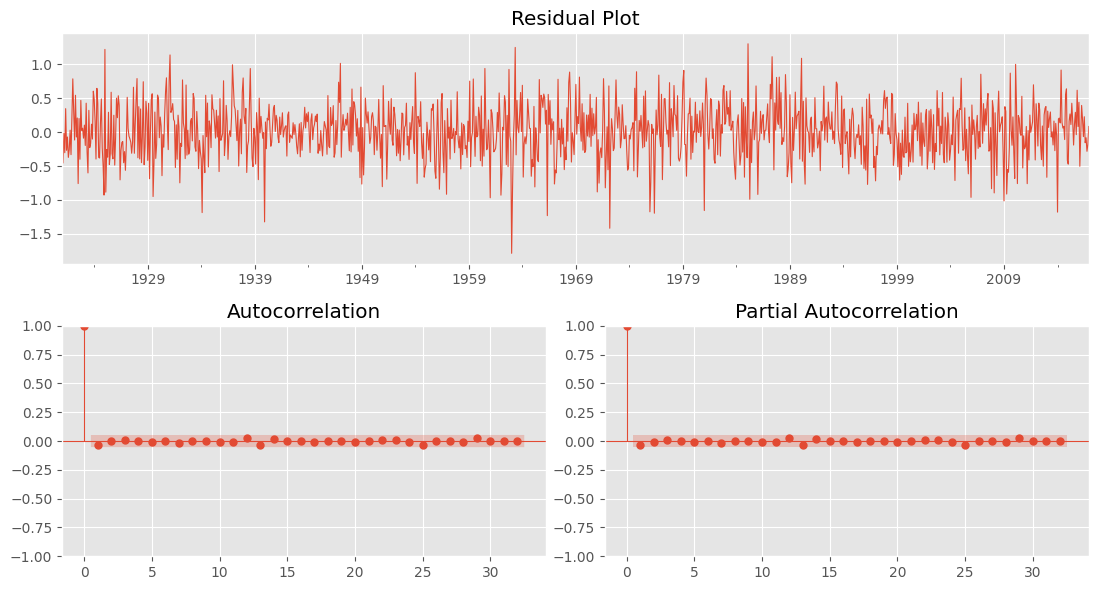

In [34]:
exog_model2 = sm.tsa.ARIMA(train_ts,
                           exog=exog_train,
                           order=(1,1,2),
                           ).fit()
resid = train_ts - exog_model2.predict()
plot_cf(resid)
exog_forecast2 = exog_model2.forecast(exog=exog_test, steps=12 * 5)
print_test(test_ts, exog_forecast2)

The performance is similar with our manually choses model.

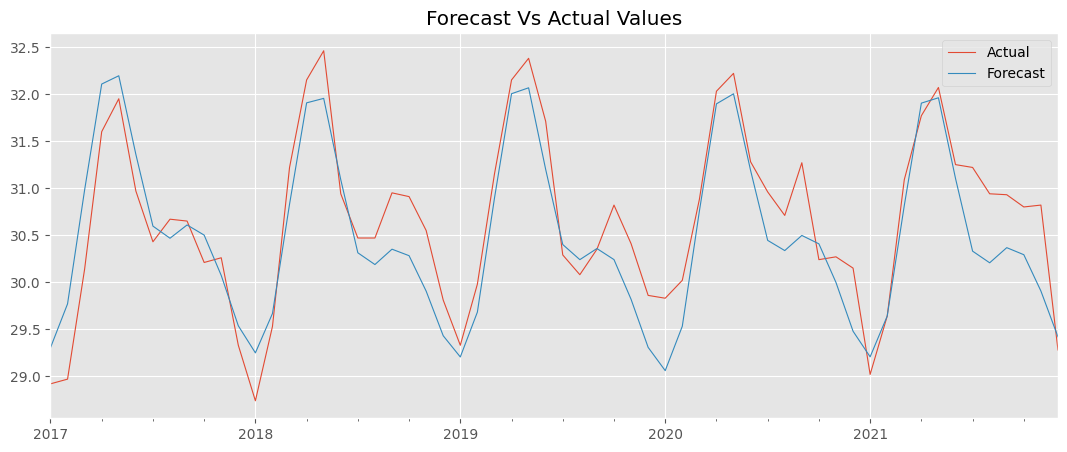

In [36]:
test_ts.plot(label="Actual")
exog_forecast2.plot(label="Forecast")
plt.title("Forecast Vs Actual Values")
plt.legend()

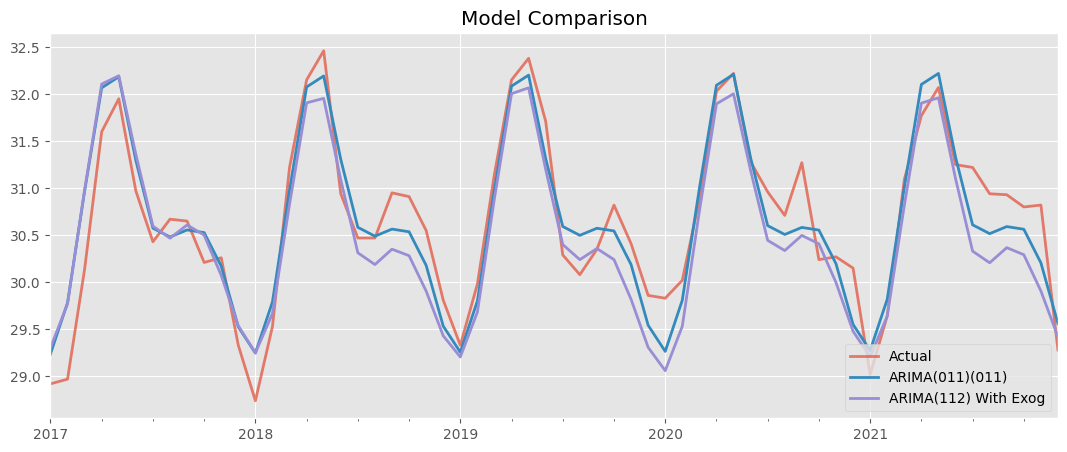

In [37]:
test_ts.plot(label="Actual", linewidth=2, alpha=0.7)
fore1.plot(label="ARIMA(011)(011)", linewidth=2)
exog_forecast2.plot(label="ARIMA(112) With Exog", linewidth=2)
plt.title("Model Comparison")
plt.legend()

## CONCLUSION
On the merit of being the simplest model and having the best performance on the test set, we conclude that the best model that we've tried for this time-series is the $ARIMA(011)(011)_{12}$ .

In [236]:
file_name = "Phl_maxtemp_forecast.csv"
path_save = os.path.join(os.path.realpath(".."), "datasets", file_name)
forecast.to_csv(path_save)